##  Python port of code and figures from the book:

### Bruno Nicenboim, Daniel Schad, and Shravan Vasishth
# An Introduction to Bayesian Data Analysis for Cognitive Science  
####  https://vasishth.github.io/bayescogsci/book/
## Chapter 4.
## @ Jozsef Arato, University of Vienna 
jozsef.arato@unvie.ac.at

## Navigable contents
[4.1: A first linear regression: Does attentional load affect pupil size?](#4.1)

[4.2: Log-normal model: Does trial affect finger tapping times?](#4.2)

[4.3:  Logistic regression: Does set size affect free recall?](#4.3)


In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.special import expit,logit

In [3]:
np.set_printoptions(precision=3)
%precision 3
pd.set_option("display.precision", 3)


## 4.1 A first linear regression: Does attentional load affect pupil size?

<a id='4.1'></a>

In [109]:
df_pupil_pilot = pd.read_csv("Data/df_pupil_pilot.csv")

In [110]:
df_pupil_pilot['p_size'].describe()

count      9.000
mean     860.778
std        6.180
min      851.500
25%      856.000
50%      862.000
75%      866.500
max      868.000
Name: p_size, dtype: float64

In [111]:
stats.norm.ppf([.025,.975],1000,500)

array([  20.018, 1979.982])

In [112]:
stats.truncnorm.ppf([.025,.975],loc=0,scale=1000,a=0,b=np.inf)

array([  31.338, 2241.403])

In [117]:
samples = stats.truncnorm.rvs(loc=0,scale=1000,a=0,b=np.inf,size=20000)
print('mean ',np.round(np.mean(samples),1))
print('std ',np.round(np.std(samples),1))

mean  797.8
std  605.7


In [118]:
stats.norm.ppf([.025,.975],0,100)

array([-195.996,  195.996])

#### Box 4.1
I dot fully understand what is being compared with:

dnorm(1, mean = 0) * 2 == dtnorm(1, mean = 0, a = 0)
 random values are not gonna be equal

In [69]:
rvs = stats.norm.rvs(loc=0,size=1)
rvs2 = stats.truncnorm.rvs(loc=0,a=0,b=np.inf,size=1)
print(rvs,rvs2)

[-0.947] [2.207]


 scipy.truncnorm a,b are in units of standard deviation, left-right to the mean,
 so we need to transform  the values provided in the book, as below
 
 (in the previous example this did not matter, a was zero)
 
 


In [128]:
loc = 300
scale = 200
a,b = 0,500
a, b = (0 - loc) / scale, (500 - loc) / scale
print(a,b)
x = stats.truncnorm.rvs(loc=loc,scale=scale,a=a,b=b,size=100000)


-1.5 1.0


In [10]:
np.mean(x)

270.171

In [11]:
np.std(x)

128.788

In [123]:
a = 0
b = 500
bar_x = 300
bar_sigma = 200
alpha = (a - bar_x) / bar_sigma
beta = (b - bar_x) / bar_sigma

term1 = ((stats.norm.pdf(beta) - stats.norm.pdf(alpha)) /
            (stats.norm.cdf(beta) - stats.norm.cdf(alpha)))


term2 = ((beta*stats.norm.pdf(beta) - alpha*stats.norm.pdf(alpha)) /
            (stats.norm.cdf(beta) - stats.norm.cdf(alpha)))

mu= bar_x - bar_sigma*term1
print(np.round(mu,3))

270.963


In [125]:
sigma = np.sqrt(bar_sigma**2 * (1 - term2 - term1**2))
print(np.round(sigma,3))

128.947


  disclosure, the below two cells were adapted from a Chat GTP translation 

In [137]:
def eq_system(x, parms):
    mu_hat = x[0]
    sigma_hat = x[1]
    alpha = (parms["a"] - mu_hat) / sigma_hat
    beta = (parms["b"] - mu_hat) / sigma_hat
    F1 = parms["mu"] - mu_hat + sigma_hat * \
    (stats.norm.pdf(beta) - stats.norm.pdf(alpha)) / (stats.norm.cdf(beta) - stats.norm.cdf(alpha))
    F2 = parms["sigma"] - sigma_hat * np.sqrt(
        (1 - ((beta) * stats.norm.pdf(beta) - (alpha) * stats.norm.pdf(alpha)) /
         (stats.norm.cdf(beta) - stats.norm.cdf(alpha)) -
         ((stats.norm.pdf(beta) - stats.norm.pdf(alpha)) /
          (stats.norm.cdf(beta) - stats.norm.cdf(alpha)))**2))
    return np.array([F1, F2])

In [138]:
from scipy.optimize import root

parms = {"a": 0, "b": 500, "mu": np.mean(x)  , "sigma": np.std(x) }

sol = root(eq_system,  np.array([1, 1]), args=(parms,))
soln = sol.x
print(soln)


[301.878 201.471]


###  4.1.2  

In [15]:
df_pupil = pd.read_csv("Data/df_pupil.csv")
df_pupil['c_load'] = df_pupil['load']-df_pupil['load'].mean()
df_pupil.head()

,Unnamed: 0,subj,trial,load,p_size,c_load
0,1,701,1,2,1021.409,-0.439
1,2,701,2,1,951.435,-1.439
2,3,701,3,5,1063.957,2.561
3,4,701,4,4,913.487,1.561
4,5,701,5,0,602.687,-2.439


In [16]:
np.shape(df_pupil)

(41, 6)

In [17]:
with pm.Model() as fit_pupil:
    # priors
    Intercept = pm.Normal('Intercept',1000, 500)
    b_c_load = pm.Normal('b_c_load',0, 100)
    sigma = pm.HalfNormal('sigma',1000)
    
    # likelihood
    p_size = pm.Normal('p_size',mu=Intercept+b_c_load*df_pupil['c_load'],sigma=sigma,observed=df_pupil['p_size'])
    
    # fit model
    trace_pupil=pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, b_c_load, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


#### FIGURE 4.2

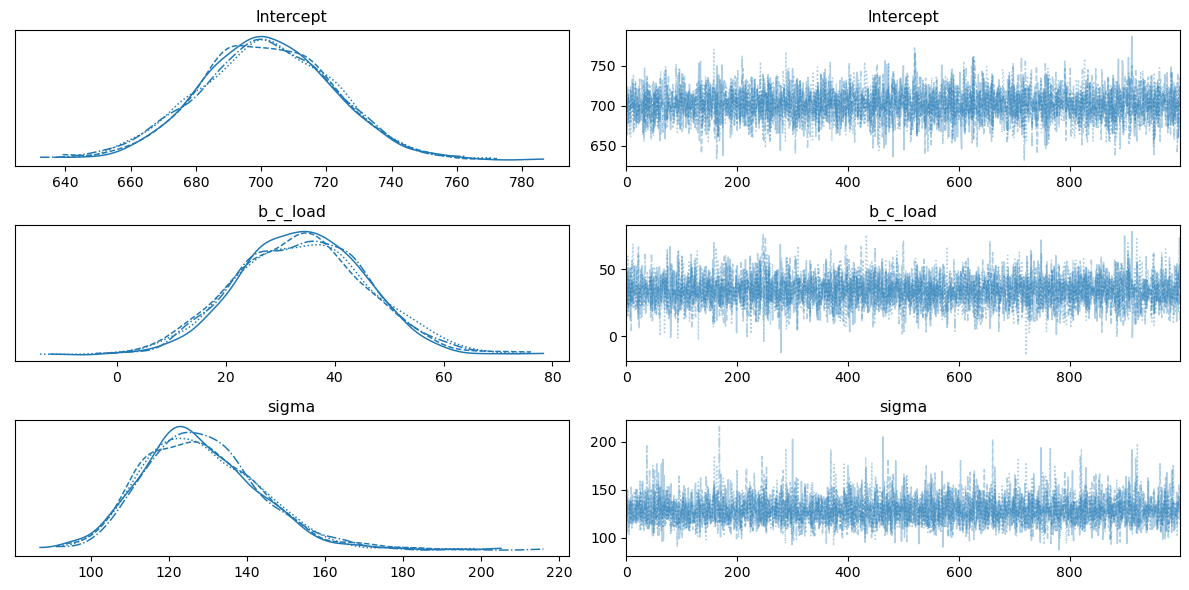

In [18]:
az.plot_trace(trace_pupil)
plt.tight_layout()

In [19]:
az.summary(trace_pupil)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,701.446,20.584,663.833,740.062,0.278,0.197,5416.0,2967.0,1.0
b_c_load,33.941,11.981,10.685,55.141,0.171,0.129,4948.0,3310.0,1.0
sigma,128.510,15.225,101.950,155.867,0.220,0.159,5078.0,3240.0,1.0


### Box 4.2

In [20]:
with pm.Model() as fit_pupil_nc:
    # priors
    Intercept = pm.Normal('Intercept',800, 2000)
    b_nc_load = pm.Normal('b_nc_load',0, 100)
    sigma = pm.HalfNormal('sigma',1000)
    
    # likelihood
    p_size = pm.Normal('p_size',mu=Intercept+b_nc_load*df_pupil['load'],sigma=sigma,observed=df_pupil['p_size'])
    
    # fit model
    trace_pupil_nc = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, b_nc_load, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [72]:
with  fit_pupil:
    pm.sample_posterior_predictive(trace=trace_pupil,extend_inferencedata=True)

    


with  fit_pupil_nc:
    pm.sample_posterior_predictive(trace=trace_pupil_nc,extend_inferencedata=True)

    


Sampling: [p_size]


Sampling: [p_size]


In [32]:
summary_c = az.summary(trace_pupil)
summary_c

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,701.446,20.584,663.833,740.062,0.278,0.197,5416.0,2967.0,1.0
b_c_load,33.941,11.981,10.685,55.141,0.171,0.129,4948.0,3310.0,1.0
sigma,128.510,15.225,101.950,155.867,0.220,0.159,5078.0,3240.0,1.0


In [31]:
summary_nc = az.summary(trace_pupil_nc)
summary_nc

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,618.469,34.777,551.804,682.710,0.806,0.570,1868.0,1955.0,1.0
b_nc_load,33.809,11.631,11.662,55.603,0.269,0.202,1871.0,1553.0,1.0
sigma,127.867,15.085,101.580,156.057,0.320,0.228,2272.0,2282.0,1.0


#### Figure 4.3

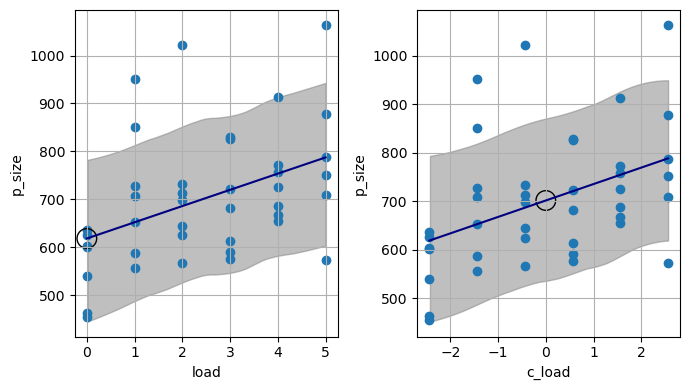

In [57]:
fig,ax = plt.subplots(ncols=2,figsize=(7,4))
xsort = np.sort(df_pupil['load'])

az.plot_hdi(df_pupil['c_load'],trace_pupil.posterior_predictive.p_size,hdi_prob=.8,ax=ax[1],color='gray')
ax[0].set_xlabel('load')

az.plot_hdi(df_pupil['load'],trace_pupil_nc.posterior_predictive.p_size,hdi_prob=.8,ax=ax[0],color='gray')
ax[0].scatter(df_pupil['load'],df_pupil['p_size'])
ax[0].plot(xsort,summary_nc['mean']['Intercept']+summary_nc['mean']['b_nc_load']*xsort,color='navy')
ax[0].scatter(0,summary_nc['mean']['Intercept'],marker='o',s=200,facecolors='none',edgecolors='k')

xsort = np.sort(df_pupil['c_load'])

ax[1].set_xlabel('c_load')
ax[1].plot(xsort,summary_c['mean']['Intercept']+summary_c['mean']['b_c_load']*xsort,color='navy')
ax[1].scatter(df_pupil['c_load'],df_pupil['p_size'])
ax[1].scatter(0,summary_c['mean']['Intercept'],marker='o',s=200,facecolors='none',edgecolors='k')

for a in ax:
    a.grid()
    a.set_ylabel('p_size')

plt.tight_layout()

### 4.1.3

In [61]:
np.array(np.mean(trace_pupil.posterior.b_c_load>0))

array(0.998)

#### Figure 4.4



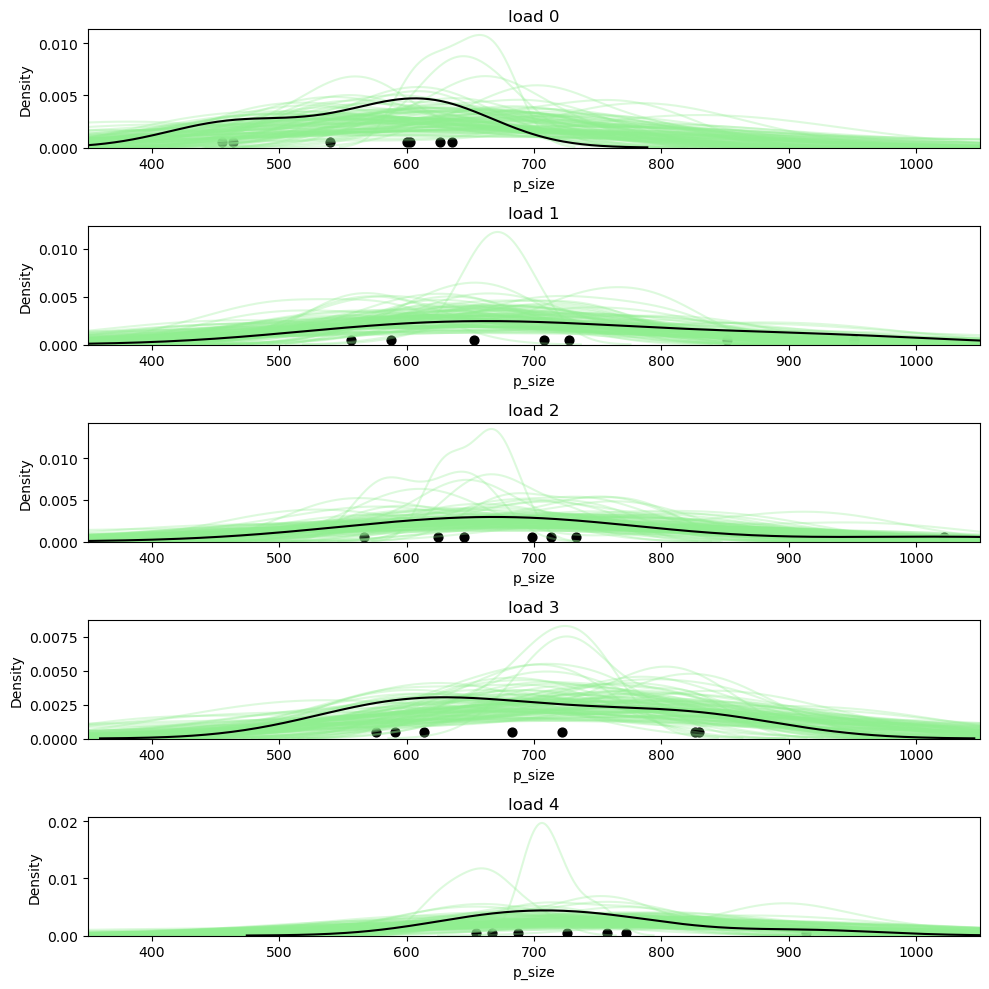

In [102]:
loads = np.arange(5)
nshow = 100
fig, ax = plt.subplots(nrows=len(loads),figsize=(10,10))
for l in loads:
    x = df_pupil['p_size'][df_pupil['load']==l]
    postsamp = trace_pupil_nc.posterior_predictive.p_size[0,:,np.array(df_pupil['load']==l)]
    
    for i in range(nshow):
        sns.kdeplot(postsamp[i,:],ax=ax[l],color='lightgreen',alpha=.3)
    ax[l].scatter(x,np.zeros(len(x))+.0005,s=40,color='k')
    sns.kdeplot(x,ax=ax[l],color='k')
    ax[l].set_xlim([350,1050])
    ax[l].set_title(f'load {l}')
plt.tight_layout()

#### FIGURE 4.5

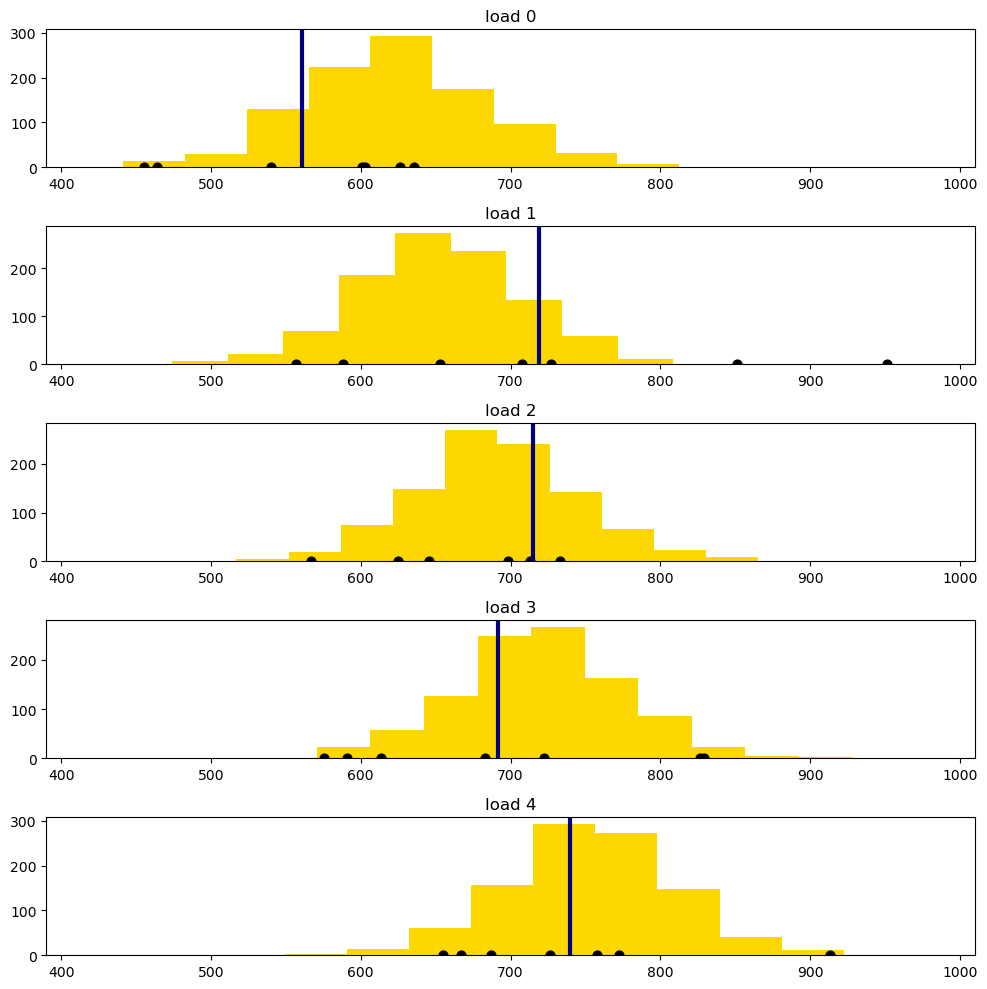

In [101]:
loads = np.arange(5)
nshow = 100
fig, ax =plt.subplots(nrows=len(loads),figsize=(10,10))
for l in loads:
    x=df_pupil['p_size'][df_pupil['load']==l]
    postsamp=trace_pupil_nc.posterior_predictive.p_size[0,:,np.array(df_pupil['load']==l)]
    ax[l].hist(np.mean(postsamp,1),color='gold')
    ax[l].scatter(x,np.zeros(len(x))+.0005,s=40,color='k')
    ax[l].axvline(np.mean(x),color='navy',linewidth=3)

    ax[l].set_xlim([390,1010])
    ax[l].set_title(f'load {l}')
plt.tight_layout()

## 4.2 Log-normal model: Does trial affect finger tapping times?

<a id='4.2'></a>


In [103]:
df_spacebar = pd.read_csv('Data/df_spacebar.csv')
df_spacebar['c_trial'] = df_spacebar['trial']-df_spacebar['trial'].mean()
df_spacebar.head()

,Unnamed: 0,t,trial,c_trial
0,1,141,1,-180.0
1,2,138,2,-179.0
2,3,128,3,-178.0
3,4,132,4,-177.0
4,5,126,5,-176.0


to reproduce the results of this section, we do not need a separate dataframe, we can just use the first dataframe with prior predictive only

In [104]:
# df_spacebar_ref=df_spacebar.copy()
# df_spacebar_ref['t']=1
# df_spacebar_ref.head()

In [105]:
with pm.Model() as press_trial:
    Intercept = pm.Normal('Intercept',6, 1.5)
    sigma = pm.HalfNormal('sigma', 1)
    c_trial = pm.Normal('c_trial',0, 1)
    t = pm.LogNormal('t',mu=Intercept+c_trial*df_spacebar['c_trial'],sigma=sigma,observed=df_spacebar['t'])
    priortrace = pm.sample_prior_predictive(samples=10000)

Sampling: [Intercept, c_trial, sigma, t]


#### Figure 4.6  
Median Diff bewteen adjacent trials

C:\Users\aratoj87\Anaconda3\envs\pymc_env\Lib\site-packages\numpy\lib\function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


(-15000.000, 15000.000)

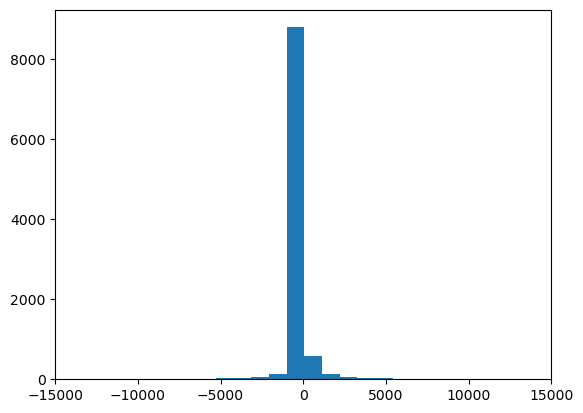

In [174]:
xx = plt.hist(np.median(np.diff(priortrace.prior_predictive.t[0,:,:],1),1),bins=200)
plt.xlim([-15000,15000])

In [106]:
with pm.Model() as press_trial:
    Intercept = pm.Normal('Intercept',6, 1.5)
    sigma = pm.HalfNormal('sigma', 1)
    c_trial = pm.Normal('c_trial',0, 0.01)
    t = pm.LogNormal('t',mu=Intercept+c_trial*df_spacebar['c_trial'],sigma=sigma,observed=df_spacebar['t'])
    priortrace2 = pm.sample_prior_predictive(samples=10000)

Sampling: [Intercept, c_trial, sigma, t]


#### Figure 4.7 
Median Diff bewteen adjacent trials

(-1500.000, 1500.000)

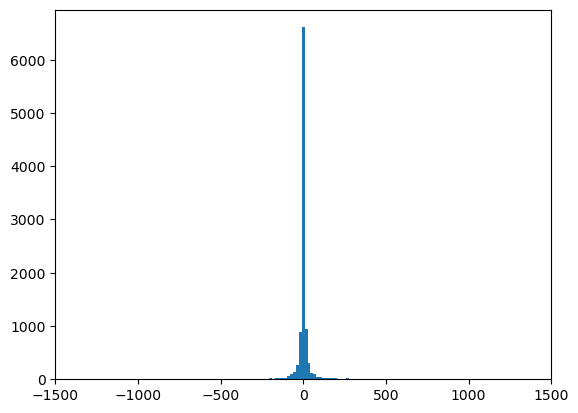

In [107]:
xx = plt.hist(np.median(np.diff(priortrace2.prior_predictive.t[0,:,:],1),1),bins=200)
plt.xlim([-1500,1500])

#### Figure 4.8

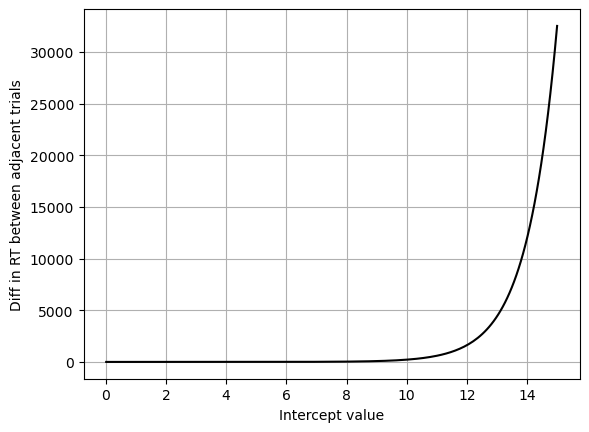

In [108]:
alphas = np.linspace(0.01,15,200)
beta = .01
n = 180 # this trial number makes the output similar to the one in the book

Y = np.exp(alphas)*(np.exp(df_spacebar['c_trial'][n]*beta)-np.exp(df_spacebar['c_trial'][n-1]*beta))

fig,ax = plt.subplots()
ax.plot(alphas,Y,color='k')
ax.set_xlabel('Intercept value')
ax.set_ylabel('Diff in RT between adjacent trials')
ax.grid()

#### Figure 4.9

Text(0.5, 0, 'Trial number')

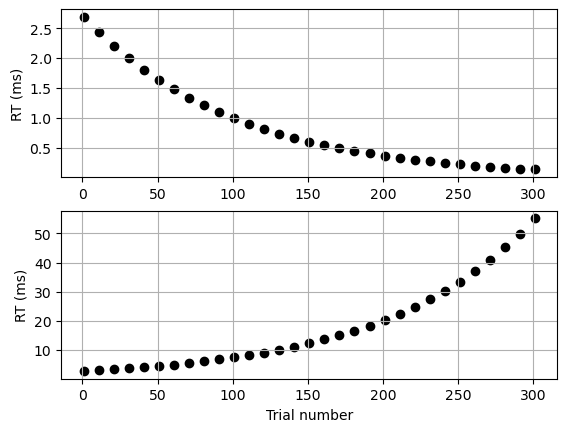

In [4]:
ns = np.arange(1,305,10)
betas = [-.01,.01]
alpha = 1
fig,ax = plt.subplots(nrows=2)
for cb,beta in enumerate(betas):
    Y = np.exp(alpha)*(np.exp(ns*beta))
    ax[cb].scatter(ns,Y,color='k')
    ax[cb].grid()
    ax[cb].set_ylabel('RT (ms)')
ax[cb].set_xlabel('Trial number')


#### Figure 4.10

Text(0.5, 0, 'Trial number')

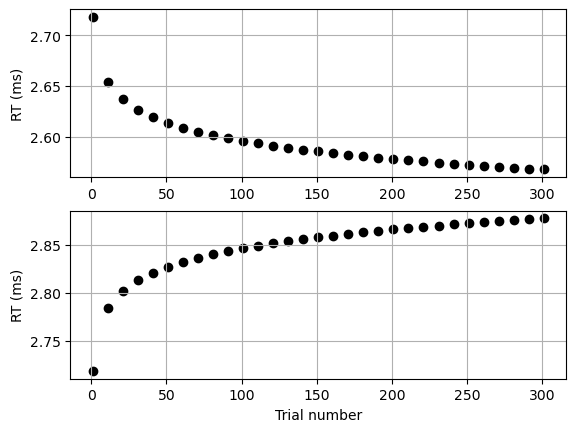

In [5]:
fig,ax=plt.subplots(nrows=2)
for cb,beta in enumerate(betas):
    Y=np.exp(alpha)*np.exp(np.log(ns)*beta)
    ax[cb].scatter(ns,Y,color='k')
    ax[cb].grid()
    ax[cb].set_ylabel('RT (ms)')
ax[cb].set_xlabel('Trial number')


### 4.2.2

In [142]:
with pm.Model() as press_trial:
    Intercept=pm.Normal('Intercept',6, 1.5)
    sigma=pm.Normal('sigma',0, 1)
    c_trial=pm.Normal('c_trial',0, 0.01)
    t=pm.LogNormal('t',mu=Intercept+c_trial*df_spacebar['c_trial'],sigma=sigma,observed=df_spacebar['t'])
    trace_press_trial=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sigma, c_trial]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


In [292]:
az.summary(trace_press_trial)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,5.118,0.007,5.106,5.131,0.0,0.0,5992.0,2838.0,1.0
sigma,0.123,0.005,0.115,0.133,0.0,0.0,5827.0,3154.0,1.0
c_trial,0.001,0.000,0.000,0.001,0.0,0.0,4867.0,2939.0,1.0


#### Figure 4.11

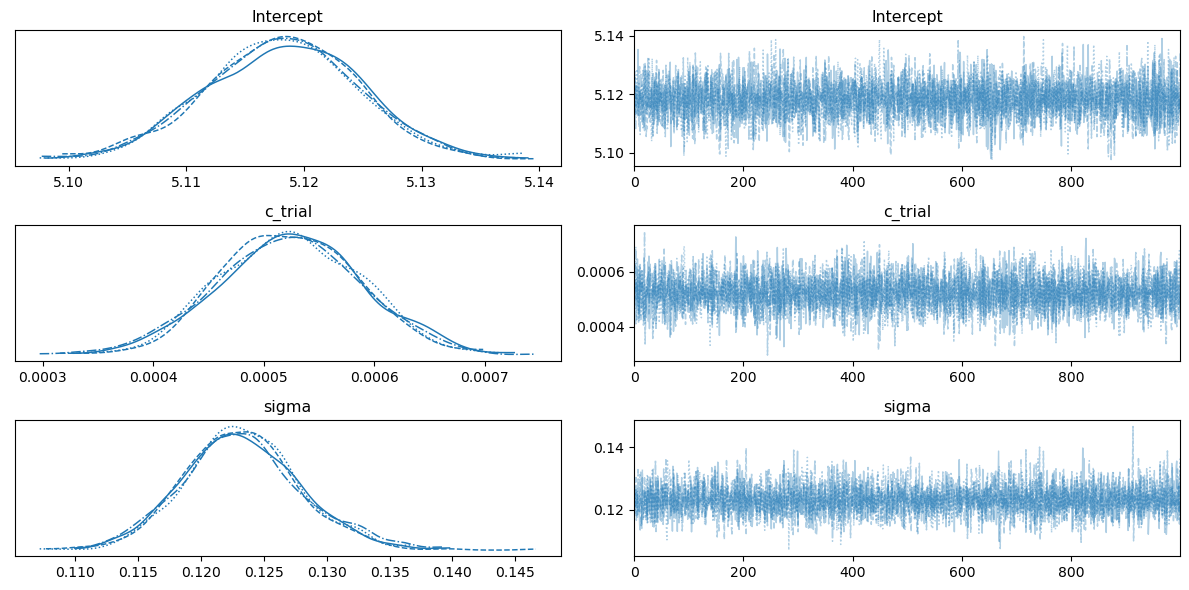

In [290]:
az.plot_trace(trace_press_trial)
plt.tight_layout()

### 4.2.3

In [146]:
alpha_samples = np.array(trace_press_trial.posterior.Intercept).flatten()
beta_samples = np.array(trace_press_trial.posterior.c_trial).flatten()
effect_middle_ms = np.exp(alpha_samples)-np.exp(alpha_samples-1*beta_samples)
print('mean',np.round(np.mean(np.mean(effect_middle_ms)),4))
print('2.5%, 97.5%',np.percentile(effect_middle_ms,[2.5,97.5]))

mean 0.0875
2.5%, 97.5% [0.068 0.108]


In [147]:
first_trial = np.min(df_spacebar['c_trial'])
second_trial = np.min(df_spacebar['c_trial'])+1
effect_beginning_ms = np.exp(alpha_samples+second_trial*beta_samples)-np.exp(alpha_samples+first_trial*beta_samples)
print('mean',np.round(np.mean(np.mean(effect_beginning_ms)),4))
print('2.5%, 97.5%',np.percentile(effect_beginning_ms,[2.5,97.5]))

mean 0.0796
2.5%, 97.5% [0.063 0.096]


 with the posterior predictive method  (which  is is similar to the "fitted" method in brms used in the book), I cannot reproduce the narrow confidence interval, that is in the book

In [143]:
with press_trial:
    post = pm.sample_posterior_predictive(trace=trace_press_trial)
    


Sampling: [t]


In [148]:
tr1 = np.array(post.posterior_predictive.t[:,:,df_spacebar['c_trial']==first_trial]).flatten()
tr2 = np.array(post.posterior_predictive.t[:,:,df_spacebar['c_trial']==second_trial]).flatten()

In [340]:
tr1.mean(),tr2.mean()

(153.419, 153.528)

In [149]:
print('mean',np.round(np.mean(tr2-tr1),4))
print('2.5%, 97.5%',np.percentile(tr2-tr1,[2.5,97.5]))

mean -0.0445
2.5%, 97.5% [-52.561  53.183]


In [150]:
effect_100=np.exp(alpha_samples+100*beta_samples)-np.exp(alpha_samples)
print('mean',np.round(np.mean(np.mean(effect_100)),4))
print('2.5%, 97.5%',np.percentile(effect_100,[2.5,97.5]))

mean 8.9921
2.5%, 97.5% [ 6.945 11.116]


### 4.2.4
I dont know of such a simple way to calculate in arviz the same statistics as in the book,
but we can just use numpy and posterior.predictive to calculate the same thing...

In [375]:

lag = 100
trs = np.arange(df_spacebar['c_trial'][0],np.max(df_spacebar['c_trial'])-lag)
lagdiffs_posterior  = np.zeros((len(np.array(post.posterior_predictive.t[:,:,0]).flatten()),len(trs)))
lagdiffs_true = np.zeros(len(trs))
for ct,tr in enumerate(trs): 
    if tr+lag < np.max(df_spacebar['c_trial']):
        tr1 = np.array(post.posterior_predictive.t[:,:,df_spacebar['c_trial']==tr]).flatten()
        trlag=np.array(post.posterior_predictive.t[:,:,df_spacebar['c_trial']==tr+lag]).flatten()
        lagdiffs_posterior[:,ct] = trlag-tr1
        lagdiffs_true[ct] = np.intp(df_spacebar['t'][df_spacebar['c_trial']==tr+lag])-np.intp(df_spacebar['t'][df_spacebar['c_trial']==tr])
lagdiffs_posterior = np.median(lagdiffs_posterior,1)


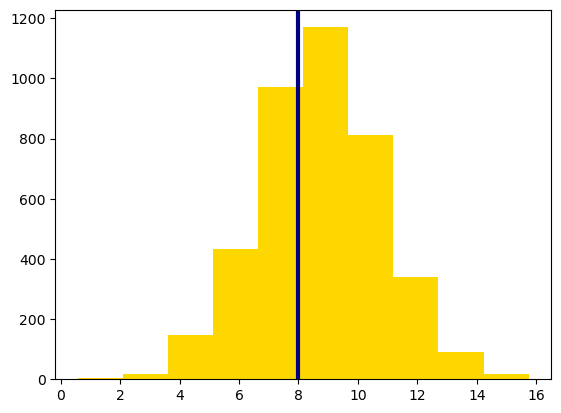

In [377]:
fig,ax = plt.subplots()
ax.hist(lagdiffs_posterior,color='gold')
ax.axvline(np.median(lagdiffs_true),color='navy',linewidth=3)


## 4.3 Logistic regression: Does set size affect free recall?

<a id='4.3'></a>

In [6]:
df_recall = pd.read_csv('Data/df_recall.csv')

In [7]:
df_recall['c_set_size'] = df_recall['set_size']-df_recall['set_size'].mean()
np.unique(df_recall['set_size'])


array([2, 4, 6, 8], dtype=int64)

In [6]:
df_recall.groupby(['set_size']).count()

,Unnamed: 0,subj,correct,trial,session,block,tested,c_set_size
set_size,,,,,,,,
2,23,23,23,23,23,23,23,23
4,23,23,23,23,23,23,23,23
6,23,23,23,23,23,23,23,23
8,23,23,23,23,23,23,23,23


In [391]:
df_recall.head()

,Unnamed: 0,subj,set_size,correct,trial,session,block,tested,c_set_size
0,1,10,4,1,1,1,1,2,-1.0
1,2,10,8,0,4,1,1,8,3.0
2,3,10,2,1,9,1,1,2,-3.0
3,4,10,6,1,23,1,1,2,1.0
4,5,10,4,1,5,1,2,3,-1.0


### 4.3.1.

In [395]:
np.random.binomial(n=1,p=.5,size=10)

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1])

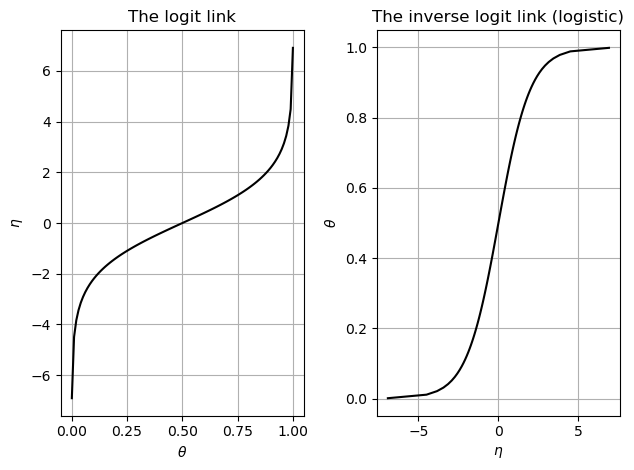

In [9]:
N=100
thetas = np.linspace(0.001,.999,N)
fig,ax = plt.subplots(ncols=2)
etas = np.log(thetas/(1-thetas))
ax[0].plot(thetas,etas,color='k')
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel(r'$\eta$')
ax[0].set_title('The logit link')

ax[1].plot(etas,1/(1+np.exp(-etas)),color='k')
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\theta$')
ax[1].set_title('The inverse logit link (logistic)')

for a in ax:
    a.grid()
plt.tight_layout()

### 4.3.2.

#### FIGURE 4.15

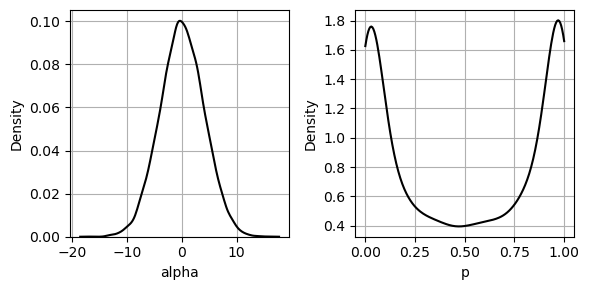

In [10]:
from scipy.special import logit,expit

N=10000
sample_logodds=np.random.normal(0,4,N)
sample_prob=expit(np.random.normal(0,4,N))
fig,ax=plt.subplots(ncols=2,figsize=(6,3))
sns.kdeplot(sample_logodds,ax=ax[0],color='k')
sns.kdeplot(sample_prob,ax=ax[1],clip=[0,1],color='k')
ax[0].set_xlabel('alpha')
ax[1].set_xlabel('p')

for a in ax:
    a.grid()
plt.tight_layout()

#### FIGURE 4.16

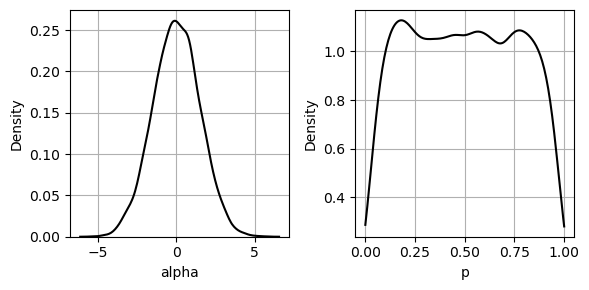

In [11]:

N=10000
sample_logodds=np.random.normal(0,1.5,N)
sample_prob=expit(np.random.normal(0,1.5,N))
fig,ax=plt.subplots(ncols=2,figsize=(6,3))
sns.kdeplot(sample_logodds,ax=ax[0],color='k')
sns.kdeplot(sample_prob,ax=ax[1],clip=[0,1],color='k')
ax[0].set_xlabel('alpha')
ax[1].set_xlabel('p')

for a in ax:
    a.grid()
plt.tight_layout()

### Box 4.4

In [12]:
def logistic_model_pred (alpha_samples, beta_samples, set_size,N_obs):
    xx=np.zeros((0,4))
    c_set_size=set_size-np.mean(set_size)
    for i,alphbeta in enumerate(zip(alpha_samples, beta_samples)):
        theta=expit(alphbeta[0]+alphbeta[1]*c_set_size)
        x=np.column_stack((np.arange(N_obs),np.random.binomial(1,theta,N_obs),set_size,np.full(N_obs,i)))        
        xx=np.vstack((xx,x))
    return pd.DataFrame(data=xx,columns=['trialn','correct_pred','set_size','iter'])

In [13]:
N_obs = 800

N=1000
set_s=np.array([2, 4, 6, 8])
set_size = np.repeat(set_s, 200)
alpha_samples=np.random.normal( 0, 1.5,N)
sds_beta = np.flip(np.array([1, 0.5, 0.1, 0.01, 0.001]))

10-20 sec run-time:

In [14]:
preds_betas={}
for sd in sds_beta:
    beta_samples=np.random.normal( 0, sd,N)
    df=logistic_model_pred(
        alpha_samples = alpha_samples,
        beta_samples = beta_samples,
        set_size = set_size,
        N_obs = N_obs)
    preds_betas[sd]=df
    

#### Figure 4.17
 relatively long run-time (1-2 mins)

Text(-0.04, 0.5, 'set size')

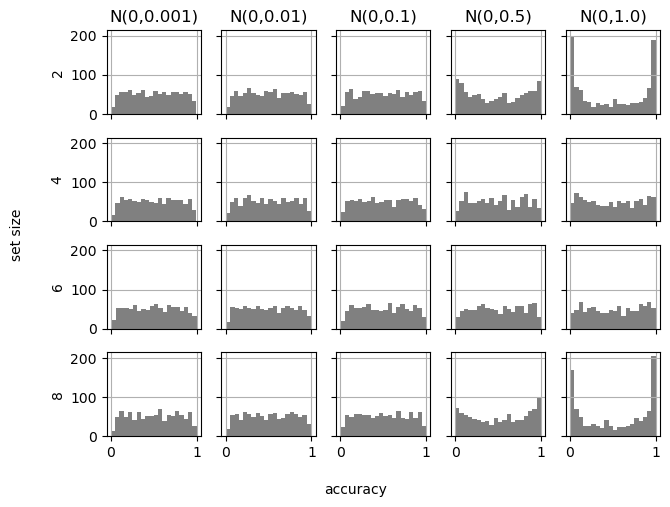

In [15]:
fig,ax = plt.subplots(ncols=len(sds_beta),nrows=len(set_s),sharey=True,sharex=True)
s = 2
it = 0
cbeta = 0
for csd,sd in enumerate(sds_beta):
    ax[0,csd].set_title(f'N(0,{sd})')
    for cset,s in enumerate(set_s):
        ax[cset,0].set_ylabel(s)
        cc = []
        for it in range(N): 
            idx = (preds_betas[sd]['set_size']==s)&(preds_betas[sd]['iter']==it)
            cc.append(np.mean(preds_betas[sd]['correct_pred'][idx]))
        ax[cset,csd].hist(np.array(cc),color='gray',bins=20)
        ax[cset,csd].grid()
plt.tight_layout()

fig.text(0.5, -0.04, 'accuracy', ha='center')
fig.text(-0.04, 0.5, 'set size', va='center', rotation='vertical')


#### Figure 4.18

Text(0.5, -0.04, 'diff_accuracy')

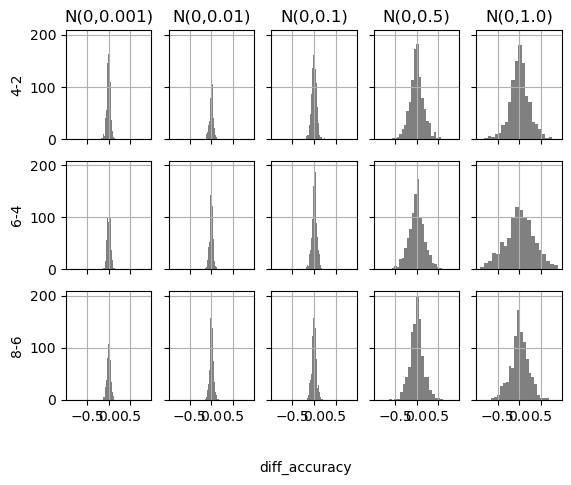

In [487]:
s1s=[4,6,8]
fig,ax=plt.subplots(ncols=len(sds_beta),nrows=len(s1s),sharey=True,sharex=True)

for csd,sd in enumerate(sds_beta):
    ax[0,csd].set_title(f'N(0,{sd})')
    diffarr=[]
    for cset,s in enumerate(s1s):
        ax[cset,0].set_ylabel(f'{s}-{s-2}')
        diffarr=[]
        for it in range(N):
            idx1 = (preds_betas[sd]['set_size']==s)&(preds_betas[sd]['iter']==it)
            idx2 = (preds_betas[sd]['set_size']==(s-2))&(preds_betas[sd]['iter']==it)
            ac1 = np.mean(preds_betas[sd]['correct_pred'][idx1])
            ac2 = np.mean(preds_betas[sd]['correct_pred'][idx2])
            diffarr.append(ac1-ac2)
        ax[cset,csd].hist(np.array(diffarr),color='gray',bins=20)
        ax[cset,csd].grid() 
fig.text(0.5, -0.04, 'diff_accuracy', ha='center')


### 4.3.3.

In [16]:
with pm.Model() as fit_recall:
    c_set_size = pm.MutableData('c_set_size',df_recall['c_set_size']) # use mutable data, so that we can do posterior predicitons for unobserved data later
    Intercept = pm.Normal('Intercept',0, 1.5)
    b_c_set_size = pm.Normal('b_c_set_size',0, 0.1)
    theta = pm.math.sigmoid(Intercept+b_c_set_size*c_set_size)
    correct = pm.Bernoulli('correct',p=theta,observed=df_recall['correct'])
    trace_recall = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, b_c_set_size]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [515]:
az.summary(trace_recall)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.926,0.310,1.354,2.494,0.005,0.004,3592.0,3083.0,1.0
b_c_set_size,-0.185,0.081,-0.345,-0.042,0.001,0.001,4204.0,3211.0,1.0


#### Figure 4.19

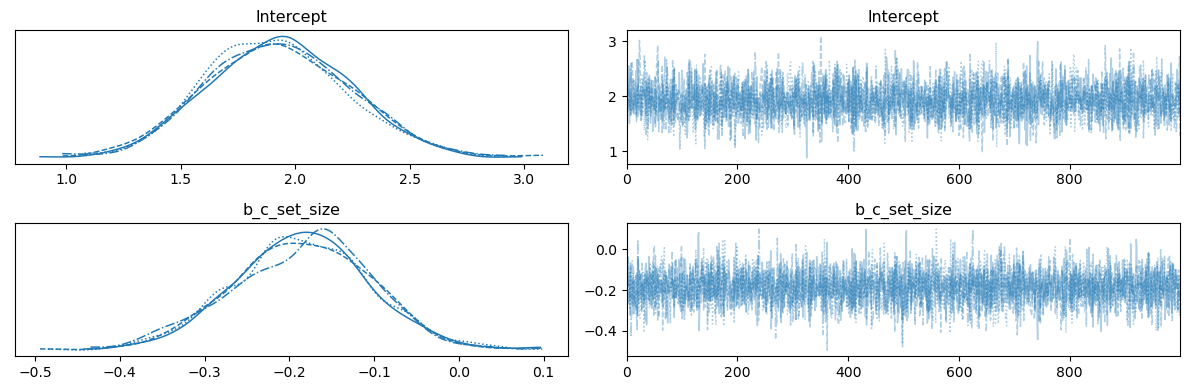

In [516]:
az.plot_trace(trace_recall)
plt.tight_layout()

### 4.3.4 How to communicate the results?

In [11]:
alpha_samples = np.array(trace_recall.posterior.Intercept).flatten()
print('mean',np.round(np.mean(expit(alpha_samples)),3))
print('2.5%, 97.5%',np.percentile(expit(alpha_samples),[2.5,97.5]))

mean 0.868
2.5%, 97.5% [0.792 0.929]


In [15]:
beta_samples = np.array(trace_recall.posterior.b_c_set_size).flatten()
effect_middle = expit(alpha_samples)-expit(alpha_samples-beta_samples)

print('mean',np.round(np.mean(effect_middle),4))
print('2.5%, 97.5%',np.percentile(effect_middle,[2.5,97.5]))

mean -0.0188
2.5%, 97.5% [-0.037 -0.003]


In [16]:
four = 4 - np.mean(df_recall['set_size'])
two = 2 - np.mean(df_recall['set_size'])
effect_4m2  = expit(alpha_samples+four*beta_samples)-expit(alpha_samples+two*beta_samples)
print('mean',np.round(np.mean(effect_4m2),4))
print('2.5%, 97.5%',np.percentile(effect_4m2,[2.5,97.5]))

mean -0.0294
2.5%, 97.5% [-0.053 -0.005]


In [12]:
with fit_recall:
    pm.set_data({'c_set_size': [0]})
    pp_recall0 = pm.sample_posterior_predictive(trace=trace_recall)

Sampling: [correct]


In [23]:
print('mean',np.mean(np.mean(pp_recall0.posterior_predictive.correct,2)))
az.hdi(np.mean(pp_recall0.posterior_predictive.correct,2),hdi_prob=.95).correct

mean <xarray.DataArray 'correct' ()>
array(0.869)


<xarray.DataArray 'correct' (hdi: 2)>
array([0.761, 0.946])
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'

In [29]:

c_set_size = np.repeat(np.array([0, -1, four, two]),int(len(df_recall)/4))
with fit_recall:
    pm.set_data({'c_set_size': c_set_size})
    pp_recall4=pm.sample_posterior_predictive(trace=trace_recall)

Sampling: [correct]


In [35]:
eff_mid = np.mean(pp_recall4.posterior_predictive.correct[:,:,c_set_size==0],2)-np.mean(pp_recall4.posterior_predictive.correct[:,:,c_set_size==-1],2)
effect_4m2 = np.mean(pp_recall4.posterior_predictive.correct[:,:,c_set_size==four],2)-np.mean(pp_recall4.posterior_predictive.correct[:,:,c_set_size==two],2)


with the above, I get broader HDIs than the book, though the mean is the same  
(possibly, I use less trials for making the predictions)

In [151]:
print('mean',np.round(np.mean(eff_mid),4))
print('2.5%, 97.5%',np.percentile(eff_mid,[2.5,97.5]))   

mean <xarray.DataArray 'correct' ()>
array(-0.017)
2.5%, 97.5% [-0.196  0.13 ]


In [37]:
print('mean',np.round(np.mean(effect_4m2),4))
print('2.5%, 97.5%',np.percentile(effect_4m2,[2.5,97.5]))   

mean <xarray.DataArray 'correct' ()>
array(-0.029)
2.5%, 97.5% [-0.174  0.13 ]


### 4.3.5

In [84]:
set_size357 = np.repeat(np.array([3,5,7]),31)
set_size357 = set_size357[:-1]  # this is really not elegant, but for me posterior predicitve works smoothly, if new data has the same dimensions as the original, that was use to fit the model
c_set_size357 = set_size357-df_recall['set_size'].mean()

In [62]:
with fit_recall:
    pm.set_data({'c_set_size': df_recall['c_set_size']})
    pp_original=pm.sample_posterior_predictive(trace=trace_recall)

Sampling: [correct]


In [85]:
with fit_recall:
    pm.set_data({'c_set_size': c_set_size357})
    pp_recall357=pm.sample_posterior_predictive(trace=trace_recall)

Sampling: [correct]


#### Figure 4.20

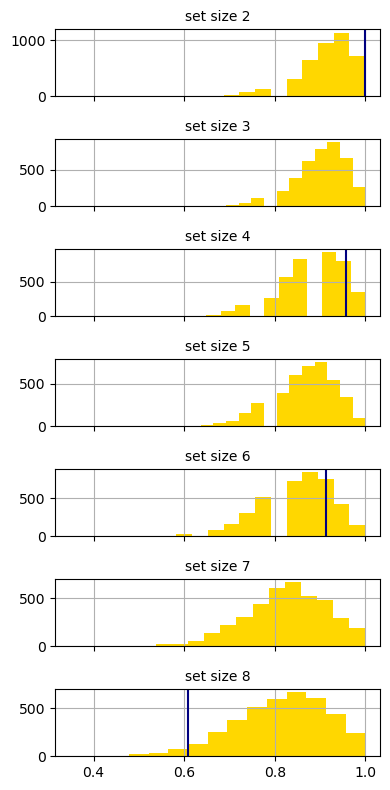

In [100]:
all_setssizes = np.arange(2,9)
fig,ax = plt.subplots(nrows=len(all_setssizes),figsize=(4,8),sharex=True)
for cs,s in enumerate(all_setssizes):
    if s in set_size:
        PostPredDistr = np.mean(pp_original.posterior_predictive.correct[:,:,df_recall['set_size']==s],2)
        ax[cs].axvline(np.mean(df_recall['correct'][df_recall['set_size']==s]),color='navy')
    elif s in set_size357:
        PostPredDistr=np.mean(pp_recall357.posterior_predictive.correct[:,:,set_size357==s],2)
    ax[cs].hist(np.array(PostPredDistr).flatten(),color='gold',bins=15)
    ax[cs].set_title(f'set size {s}',fontsize=10)
    ax[cs].grid()
plt.tight_layout()